In [71]:
import cv2
import time
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

### Detect the Face using Haar Cascade Classifier

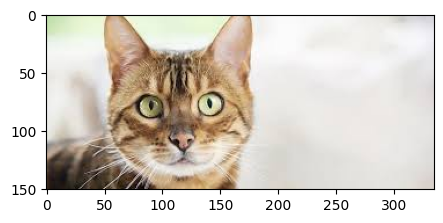

In [72]:
face = cv2.imread("../images/cat.jpg")
face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5, 5))
plt.imshow(face)
plt.show()

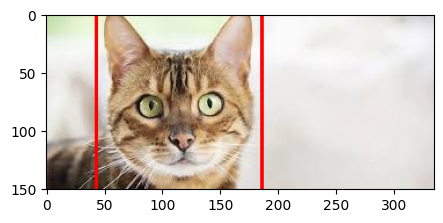

In [73]:
detector = cv2.CascadeClassifier("../data/haarcascade_frontalcatface_extended.xml")
results = detector.detectMultiScale(face, 1.1)
face_copy = np.copy(face)
for (x, y, w, h) in results:
    cv2.rectangle(face_copy, (x-15, y-40), (x+w+15, y+h+20), (255, 0, 0), 2)

plt.figure(figsize=(5, 5))
plt.imshow(face_copy)
plt.show()



### Segment the face


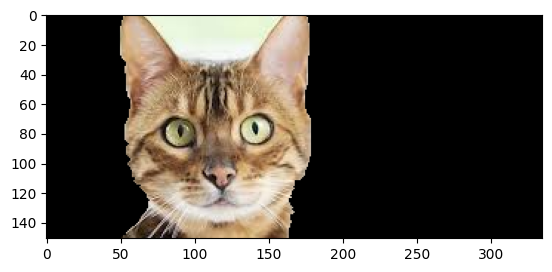

Total time taken for segmentation: 0.32 seconds


In [74]:
# segment out the face using grabcut
st = time.time()
bgModel = np.zeros((1, 65), np.float64)
fgModel = np.zeros((1, 65), np.float64)

mask = np.zeros(face.shape[:2], np.uint8)

rect = (results[0][0]-15, results[0][1]-40, results[0][2]+30, results[0][3]+60)
face_copy = np.copy(face)
cv2.grabCut(face_copy, mask, rect, bgModel, fgModel, 5, cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
face_copy = face_copy*mask2[:, :, np.newaxis]

plt.imshow(face_copy)
plt.show()

et = time.time()
print(f"Total time taken for segmentation: {et-st:.2f} seconds")

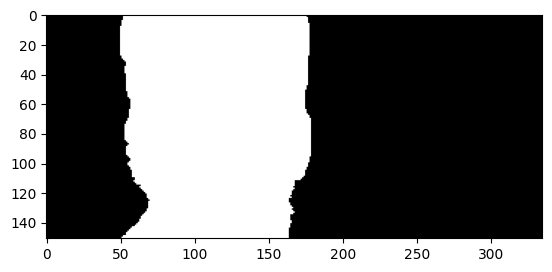

In [75]:
# display face mask
plt.imshow(mask2, cmap='gray')
plt.show()

#### Smoothen the mask using Gaussian Blurring

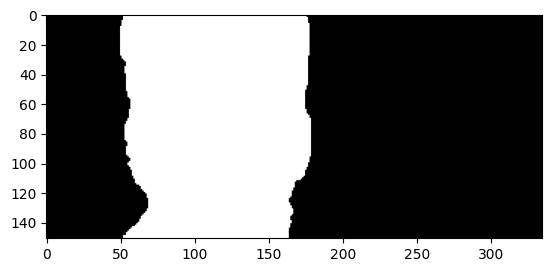

In [76]:
# smoothen the mask with a gaussian filter
mask2 = cv2.GaussianBlur(mask2, (5, 5), 0)
plt.imshow(mask2, cmap='gray')
plt.show()

### Face Landmarks


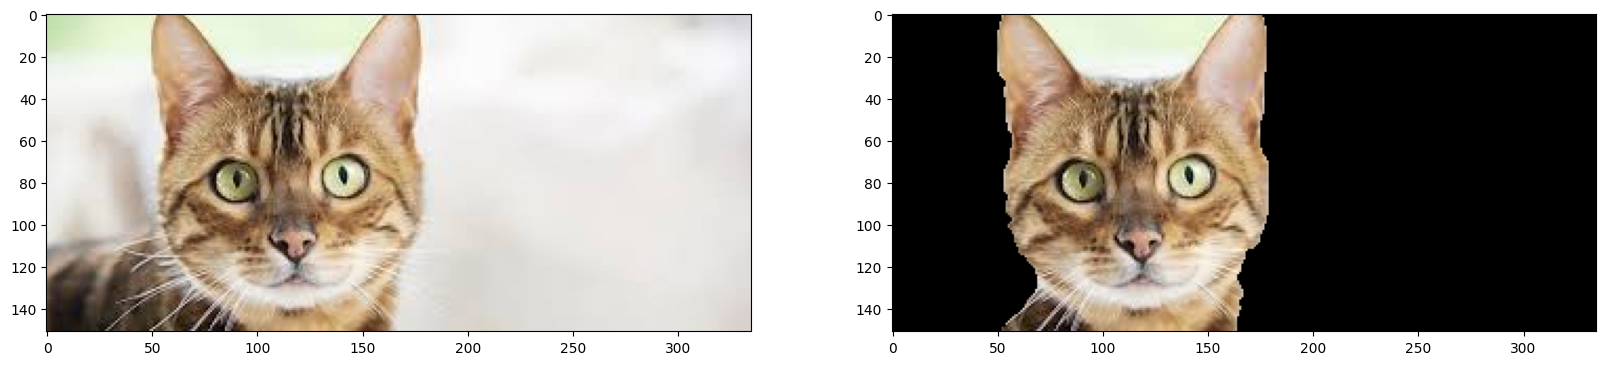

In [77]:
# mpDraw = mp.solutions.drawing_utils
# mpFaceMesh = mp.solutions.face_mesh
# face_mesh = mpFaceMesh.FaceMesh(max_num_faces=1)
# drawSpec = mpDraw.DrawingSpec(thickness=1, circle_radius=1)

face_copy = np.copy(face)
# landmarks = face_mesh.process(face_copy)
# if landmarks.multi_face_landmarks:
#     for face_landmarks in landmarks.multi_face_landmarks:
#         mpDraw.draw_landmarks(face_copy, face_landmarks, mpFaceMesh.FACEMESH_CONTOURS, drawSpec, drawSpec)


segmented_face = np.multiply(face_copy, mask2[:, :, np.newaxis])
plt.figure(figsize=(20, 20))
plt.subplot(1,2,1)
# plt.title("Face With Landmarks")
plt.imshow(face_copy)
plt.subplot(1,2,2)
# plt.title("Segmented Face with landmarks")
plt.imshow(segmented_face)
plt.show()